In [39]:
import os
import numpy as np
import cv2
import mediapipe as mp
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, StandardScaler
import random
# Define paths
dataset_path = r"C:\Users\hp\Desktop\BE\BE PROJECT\CNN\STROKES"
# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(
    min_detection_confidence=0.7,
    min_tracking_confidence=0.7
)
def extract_landmarks(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = pose.process(image_rgb)
    
    if result.pose_landmarks:
        landmarks = []
        for lm in result.pose_landmarks.landmark:
            landmarks.extend([lm.x, lm.y, lm.z, lm.visibility])
        return landmarks
    else:
        return None

In [41]:
def augment_landmarks(landmarks):
    """Apply random noise and scaling to landmarks for data augmentation"""
    augmented = np.array(landmarks)
    
    # Add small random noise
    noise = np.random.normal(0, 0.01, augmented.shape)
    augmented += noise
    
    # Random scaling
    scale = random.uniform(0.95, 1.05)
    augmented *= scale
    
    return augmented.tolist()

In [43]:
def load_dataset():
    data = []
    labels = []
    for category in os.listdir(dataset_path):
        category_path = os.path.join(dataset_path, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            image = cv2.imread(img_path)
            
            if image is None:
                continue
                
            # Resize image for consistency
            image = cv2.resize(image, (640, 480))
            
            landmarks = extract_landmarks(image)
            
            if landmarks:
                # Original landmarks
                data.append(landmarks)
                labels.append(category)
                
                # Augmented versions
                for _ in range(3):  # Create 3 augmented versions
                    aug_landmarks = augment_landmarks(landmarks)
                    data.append(aug_landmarks)
                    labels.append(category)
    
    return np.array(data), np.array(labels)

In [45]:
def preprocess_data():
    print("Loading and preprocessing data...")
    data, labels = load_dataset()
    
    # Normalize landmarks
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    
    # Encode labels
    encoder = LabelBinarizer()
    labels = encoder.fit_transform(labels)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        data, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    return X_train, X_test, y_train, y_test, encoder

In [47]:
def create_improved_model(input_shape, num_classes):
    model = Sequential([
        # First dense block
        Dense(256, activation='relu', input_shape=input_shape, 
              kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.4),
        
        # Second dense block
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.4),
        
        # Third dense block
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        
        # Output layer
        Dense(num_classes, activation='softmax')
    ])
    
    # Use Adam optimizer with custom learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [51]:
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.00001
    )
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    return test_accuracy, history
# Main execution
print("Starting training process...")
X_train, X_test, y_train, y_test, encoder = preprocess_data()
input_shape = (X_train.shape[1],)
num_classes = len(encoder.classes_)
improved_model = create_improved_model(input_shape, num_classes)
accuracy, history = train_and_evaluate(improved_model, X_train, X_test, y_train, y_test)
print(f"\nFinal Model Accuracy: {accuracy * 100:.2f}%")
# Save the model
model_save_path = r"C:\Users\hp\Desktop\BE\BE PROJECT\CNN\improved_model.h5"
improved_model.save(model_save_path)
print(f"\nModel saved successfully at: {model_save_path}") 

Starting training process...
Loading and preprocessing data...


C:\Users\hp\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.7707 - loss: 4.4307 - val_accuracy: 0.9515 - val_loss: 2.5950 - learning_rate: 0.0010
Epoch 2/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9163 - loss: 2.2792 - val_accuracy: 0.9590 - val_loss: 1.3448 - learning_rate: 0.0010
Epoch 3/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9265 - loss: 1.2451 - val_accuracy: 0.9619 - val_loss: 0.7660 - learning_rate: 0.0010
Epoch 4/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9345 - loss: 0.7535 - val_accuracy: 0.9573 - val_loss: 0.5073 - learning_rate: 0.0010
Epoch 5/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9328 - loss: 0.5404 - val_accuracy: 0.9411 - val_loss: 0.4118 - learning_rate: 0.0010
Epoch 6/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9391 - loss: 0.4242 - val_accuracy: 0.9602 - val_loss: 0.3320 - learning_rate: 0.0010
Epoch 7/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9430 - 


Final Model Accuracy: 99.94%

Model saved successfully at: C:\Users\hp\Desktop\BE\BE PROJECT\CNN\improved_model.h5


In [53]:
# Plot training history
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('training_history.png')
plt.close()

In [23]:
import cv2
import mediapipe as mp
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import pyttsx3

# Define paths
model_path = r"C:\Users\hp\Desktop\BE\BE PROJECT\CNN\improved_model.h5"

# Load the trained model
if os.path.exists(model_path):
    model = load_model(model_path)
    print("Improved Model Loaded Successfully!")
else:
    raise FileNotFoundError(f"Model file not found at: {model_path}")

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

# Initialize text-to-speech engine
engine = pyttsx3.init()

# Define class labels
encoder = LabelBinarizer()
encoder.fit(["drive", "pullshot", "no_stroke"])  # Updated class labels

# Function to extract landmarks from an image
def extract_landmarks(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = pose.process(image_rgb)

    if result.pose_landmarks:
        landmarks = []
        for lm in result.pose_landmarks.landmark:
            landmarks.extend([lm.x, lm.y, lm.z, lm.visibility])
        return np.array(landmarks).reshape(1, -1)  # Reshape for model input
    else:
        return None

# Function to make predictions and overlay feedback on frame
def predict_pose(image, frame):
    landmarks = extract_landmarks(image)
    if landmarks is not None:
        prediction = model.predict(landmarks)
        class_index = np.argmax(prediction)
        class_label = encoder.classes_[class_index]

        if class_label == "drive":
            feedback = "Drive Stroke Detected"
        elif class_label == "pullshot":
            feedback = "Pull Shot Detected"
        elif class_label == "no_stroke":
            feedback = "No Stroke Detected"
        else:
            feedback = "Unknown Pose"

        # Overlay text on the frame
        cv2.putText(frame, feedback, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 
                    1, (0, 255, 0), 2, cv2.LINE_AA)

        # Speech output
        engine.say(feedback)
        engine.runAndWait()
    else:
        feedback = "No Pose Detected"
        cv2.putText(frame, feedback, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 
                    1, (0, 0, 255), 2, cv2.LINE_AA)

        engine.say(feedback)
        engine.runAndWait()

# Real-time Pose Detection using Webcam
def real_time_pose_detection():
    cap = cv2.VideoCapture(0)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Flip the frame horizontally for a natural view
        frame = cv2.flip(frame, 1)

        # Make prediction and overlay on frame
        predict_pose(frame, frame)

        # Display the frame with overlaid text
        cv2.imshow("Pose Detection", frame)

        # Press 'q' to exit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Run real-time detection
real_time_pose_detection()

Improved Model Loaded Successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━

KeyboardInterrupt: 

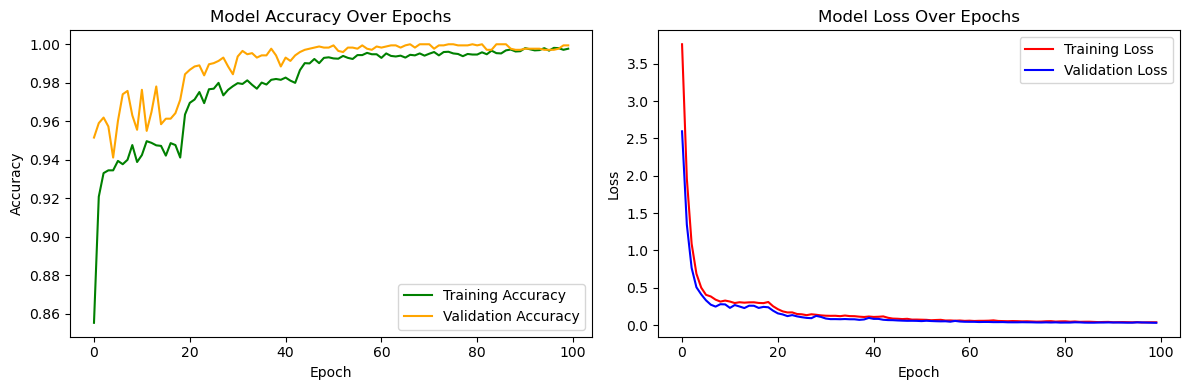

In [55]:
import matplotlib.pyplot as plt

# Plotting training and validation accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
